In [1]:
import pandas as pd
import numpy as np
import utils
import model

from sklearn.metrics import roc_curve, auc
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [2]:
sqlForTraining = """
select
	eta.idetablissement,
	eta.departement,
	eta.siren,
	eta.geores_lat,
	eta.geores_lon,
	eta.nb_agrements,
	CAST (eta.evolution_score*10 AS INTEGER) as evolution_score,
	eta.commune_norm,
	act.idactivite,
	act.categorie_frais,
	CASE 
      WHEN ins.synthese_eval = 'Très satisfaisant'  THEN 4
      WHEN ins.synthese_eval = 'Satisfaisant'  THEN 3
      WHEN ins.synthese_eval = 'A améliorer'  THEN 2
      WHEN ins.synthese_eval = 'A corriger de manière urgente'  THEN 1
	END	as synthese_eval
from inspection ins
join etablissement eta on ins.idetablissement = eta.idetablissement
join activite act on ins.idactivite = act.idactivite
order by eta.idetablissement
"""



In [3]:
df = pd.read_sql_query(sqlForTraining, model.session.connection())

df['evolution_score'].astype('int')

df = df.sample(frac=1).reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35586 entries, 0 to 35585
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   idetablissement  35586 non-null  int64  
 1   departement      35586 non-null  int64  
 2   siren            35586 non-null  object 
 3   geores_lat       35586 non-null  float64
 4   geores_lon       35586 non-null  float64
 5   nb_agrements     35586 non-null  int64  
 6   evolution_score  35586 non-null  int64  
 7   commune_norm     35586 non-null  object 
 8   idactivite       35586 non-null  int64  
 9   categorie_frais  35586 non-null  bool   
 10  synthese_eval    35586 non-null  int64  
dtypes: bool(1), float64(2), int64(6), object(2)
memory usage: 2.7+ MB


In [4]:
X = df[['siren','geores_lat', 'geores_lon', 'categorie_frais']]
X['categorie_frais'] = X['categorie_frais'].astype('int')

# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
X['siren'] = labelencoder.fit_transform(X['siren'])
# X['commune_norm'] = labelencoder.fit_transform(X['commune_norm'])

y = df['evolution_score']

C:\Users\jean\AppData\Local\Temp\ipykernel_20580\3780960797.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['categorie_frais'] = X['categorie_frais'].astype('int')
C:\Users\jean\AppData\Local\Temp\ipykernel_20580\3780960797.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['siren'] = labelencoder.fit_transform(X['siren'])


In [5]:
print(np.unique(y, return_counts=True))

(array([10, 15, 20, 22, 23, 24, 25, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40], dtype=int64), array([  110,     2,  1543,     4,    30,    10,    98,    27,    23,
       18035,     8,   117,   211,    27,   736,    30,   225,   112,
          15, 14223], dtype=int64))


In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35586 entries, 0 to 35585
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   siren            35586 non-null  int32  
 1   geores_lat       35586 non-null  float64
 2   geores_lon       35586 non-null  float64
 3   categorie_frais  35586 non-null  int32  
dtypes: float64(2), int32(2)
memory usage: 834.2 KB


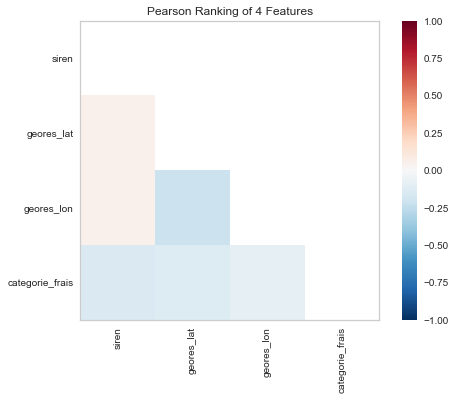

<AxesSubplot:title={'center':'Pearson Ranking of 4 Features'}>

In [7]:
from yellowbrick.features import Rank2D

r2D = Rank2D(algorithm='pearson')
r2D.fit(X)
r2D.transform(X)
r2D.show()

In [8]:
print(np.corrcoef(X, rowvar=False))

[[ 1.          0.05366793  0.04866449 -0.14224655]
 [ 0.05366793  1.         -0.21744165 -0.13783015]
 [ 0.04866449 -0.21744165  1.         -0.09184368]
 [-0.14224655 -0.13783015 -0.09184368  1.        ]]


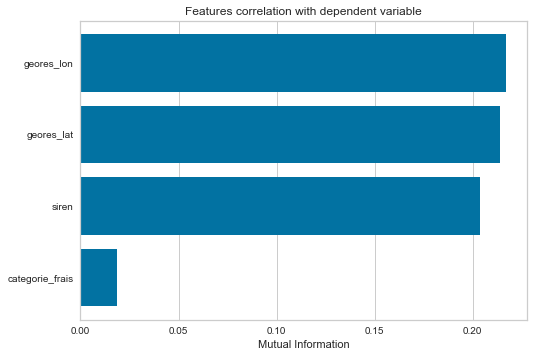

<AxesSubplot:title={'center':'Features correlation with dependent variable'}, xlabel='Mutual Information'>

In [9]:
from yellowbrick.target import FeatureCorrelation
fc = FeatureCorrelation(method='mutual_info-regression', sort=True)
fc.fit(X, y, discrete_features=False)
fc.show()

In [10]:
XTrain, XTest, yTrain, yTest = train_test_split(X, y, train_size=0.6, random_state=42)

In [11]:
print(yTrain.value_counts(normalize=True))
print(yTest.value_counts(normalize=True))


30    0.507564
40    0.398342
20    0.043886
35    0.020374
37    0.006885
33    0.005667
32    0.003138
25    0.003091
10    0.003044
38    0.002998
36    0.001077
23    0.001030
27    0.000749
28    0.000656
34    0.000562
24    0.000422
39    0.000328
31    0.000141
15    0.000047
Name: evolution_score, dtype: float64
30    0.505655
40    0.401686
20    0.042571
35    0.021145
33    0.006322
37    0.005479
32    0.003512
38    0.003372
10    0.003161
25    0.002248
34    0.001054
27    0.000773
28    0.000632
23    0.000562
39    0.000562
36    0.000492
31    0.000351
22    0.000281
15    0.000070
24    0.000070
Name: evolution_score, dtype: float64


In [12]:
from sklearn.preprocessing import StandardScaler
stdSc = StandardScaler()

In [13]:
ZTrain = stdSc.fit_transform(XTrain)
ZTest = stdSc.transform(XTest)

In [14]:
from sklearn.linear_model import LogisticRegression
# reg = LogisticRegression(solver='liblinear')

from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
# reg=RandomForestClassifier(n_estimators=1000)

from sklearn.ensemble import GradientBoostingClassifier

# reg = GradientBoostingClassifier()

from xgboost import XGBClassifier

reg = XGBClassifier( learning_rate =0.01,
 n_estimators=2000,
 max_depth=20,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

reg.fit(ZTrain, yTrain)

C:\Anaconda3\envs\ProjetAlimconfiance\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Anaconda3\envs\ProjetAlimconfiance\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:40:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:40:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=2000, n_jobs=4, nthread=4, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=27,
              reg_alpha=0.005, reg_lambda=1, scale_pos_weight=1, seed=27,
              subsample=0.8, tree_method='exact', validate_parameters=1, ...)

C:\Anaconda3\envs\ProjetAlimconfiance\lib\site-packages\yellowbrick\model_selection\importances.py:194: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


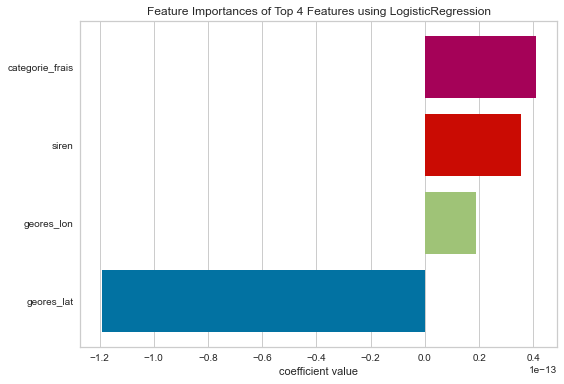

<AxesSubplot:title={'center':'Feature Importances of Top 4 Features using LogisticRegression'}, xlabel='coefficient value'>

In [15]:
from yellowbrick.model_selection import FeatureImportances
clfFI = FeatureImportances(LogisticRegression(solver='sag'), relative=False, topn=4, labels=XTrain.columns)
clfFI.fit(ZTrain, yTrain)
clfFI.show()

C:\Anaconda3\envs\ProjetAlimconfiance\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Anaconda3\envs\ProjetAlimconfiance\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Anaconda3\envs\ProjetAlimconfiance\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Anaconda3\envs\ProjetAlimconfiance\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


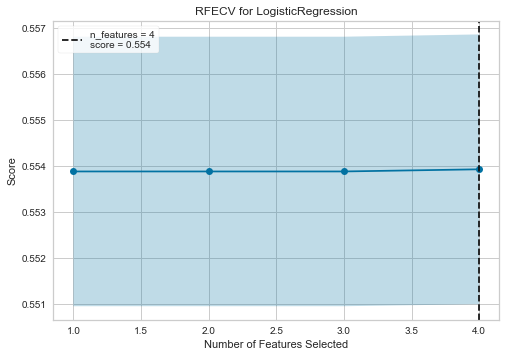

<AxesSubplot:title={'center':'RFECV for LogisticRegression'}, xlabel='Number of Features Selected', ylabel='Score'>

In [16]:
from yellowbrick.model_selection import RFECV
from sklearn.metrics import make_scorer, f1_score
clfFE = RFECV(LogisticRegression(solver='liblinear'), cv=3, scoring=make_scorer(f1_score,average='micro'))
clfFE.fit(ZTrain, yTrain)
clfFE.show()

In [17]:
print(XTrain.columns[clfFE.support_==False])

Index([], dtype='object')


C:\Anaconda3\envs\ProjetAlimconfiance\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


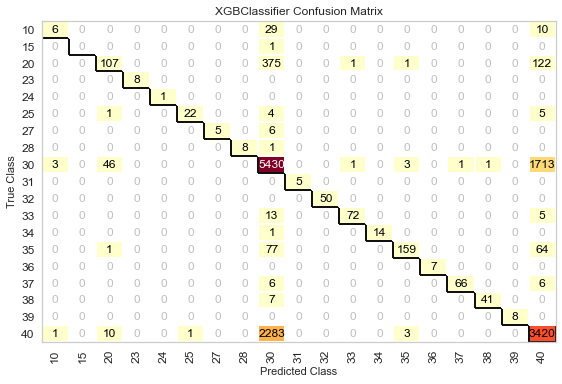

<AxesSubplot:title={'center':'XGBClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [18]:
from yellowbrick.classifier import ConfusionMatrix
clfConfusion = ConfusionMatrix(reg)
clfConfusion.score(ZTest, yTest)
clfConfusion.show()

C:\Anaconda3\envs\ProjetAlimconfiance\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
C:\Anaconda3\envs\ProjetAlimconfiance\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


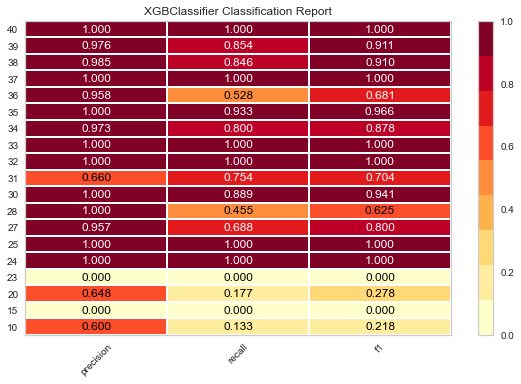

<AxesSubplot:title={'center':'XGBClassifier Classification Report'}>

In [19]:
from yellowbrick.classifier import ClassificationReport
clfReport = ClassificationReport(reg)
clfReport.score(ZTest, yTest)
clfReport.show()